In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import gzip
import shutil
import random
import xgboost as xgb
import random
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
archivo_gz='df.csv.gz'

In [3]:
archivo_descomprimido = 'df.csv'
with gzip.open(archivo_gz, 'rb') as f_in:
    with open(archivo_descomprimido, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"Archivo descomprimido guardado en: {archivo_descomprimido}")

Archivo descomprimido guardado en: df.csv


In [4]:
dataset="df.csv"
df = pd.read_csv(dataset, encoding="latin-1")

In [ ]:
def percent_data_NaN(_df):
    nan_rows_count = _df.isnull().any(axis=1).sum()
    total_rows = len(_df)
    nan_percentage = (nan_rows_count / total_rows) * 100
    print(f"El {nan_percentage:.2f}% de las filas tienen al menos un campo NaN.")

In [6]:
df["percentual_gain"] = (df["revenue"] / df["budget_x"]) * 100
df_percentgain = df
df_percentgain = df_percentgain.drop(columns=["Age","UserID","Occupation","overview","crew"])
df_percentgain = df_percentgain.drop_duplicates(subset=['MovieID'])

In [7]:
df_percentgain['date_x'] = df_percentgain['date_x'].str.strip()
df_percentgain['date_x'] = pd.to_datetime(df_percentgain['date_x'], format='%m/%d/%Y', errors='coerce')

In [8]:
df_percentgain['date_x'] = pd.to_datetime(df_percentgain['date_x'], format='%d/%m/%Y')
df_percentgain['year'] = df_percentgain['date_x'].dt.year
percent_data_NaN(df_percentgain)
df_percentgain['date_x'] = pd.to_datetime(df_percentgain['date_x'], format='%d/%m/%Y')
df_percentgain['year'] = df_percentgain['date_x'].dt.year

El 0.00% de las filas tienen al menos un campo NaN.


In [9]:
genre_mapping = {genre: idx for idx, genre in enumerate(df_percentgain['Gender_x'].unique())}
df_percentgain['genre_num'] = df_percentgain['Gender_x'].map(genre_mapping)

orig_lang_mapping = {lang: idx for idx, lang in enumerate(df_percentgain['orig_lang'].unique())}
df_percentgain['orig_lang_num'] = df_percentgain['orig_lang'].map(orig_lang_mapping)

print("Mapeo de 'genre':")
for genre, num in genre_mapping.items():
    print(f"{genre}: {num}")

print("\nMapeo de 'orig_lang':")
for lang, num in orig_lang_mapping.items():
    print(f"{lang}: {num}")

print("\nDataFrame resultante:")
print(df_percentgain[['percentual_gain', 'genre_num', 'orig_lang_num']])

Mapeo de 'genre':
Drama: 0
Animation|Children's|Musical: 1
Musical|Romance: 2
Comedy: 3
Animation|Children's: 4
Comedy|Fantasy: 5
Comedy|Sci-Fi: 6
Drama|War: 7
Romance: 8
Animation|Children's|Musical|Romance: 9
Children's|Drama|Fantasy|Sci-Fi: 10
Animation|Children's|Comedy: 11
Action|Crime|Romance: 12
Children's|Comedy|Musical: 13
Action|Drama|War: 14
Crime|Drama|Thriller: 15
Action|Adventure|Mystery: 16
Action|Adventure|Fantasy|Sci-Fi: 17
Crime|Drama: 18
Action|Thriller: 19
Comedy|Drama|Western: 20
Action|Adventure|Crime: 21
Action|Crime|Mystery|Thriller: 22
Action|Drama: 23
Action|Drama|Thriller: 24
Drama|Romance: 25
Action|Comedy|Western: 26
Adventure|Comedy|Drama: 27
Action|Crime|Thriller: 28
Drama|Sci-Fi: 29
Action|Sci-Fi|Thriller: 30
Comedy|Drama: 31
Action|Sci-Fi: 32
Adventure|Drama|Romance|Sci-Fi: 33
Action|Adventure|Sci-Fi: 34
Drama|Romance|War: 35
Comedy|Romance: 36
Adventure|Drama|Western: 37
Action|Adventure|Thriller: 38
Action|Adventure|Romance|Thriller: 39
Action|Adventu

In [10]:
df['genre_split'] = df['Gender_x'].str.split('|')
df_exploded = df.explode('genre_split')

genres_encoded = df['genre_split'].str.join('|').str.get_dummies()
df = pd.concat([df, genres_encoded], axis=1)

print(df.head())


   Unnamed: 0  UserID  MovieID  Rating  Timestamp  \
0           0       1     1193       5  978300760   
1           1       1      661       3  978302109   
2           2       1      914       3  978301968   
3           3       1     3408       4  978300275   
4           4       1      594       4  978302268   

                                    Title                      Gender_x  \
0  One Flew Over the Cuckoo's Nest (1975)                         Drama   
1        James and the Giant Peach (1996)  Animation|Children's|Musical   
2                     My Fair Lady (1964)               Musical|Romance   
3                  Erin Brockovich (2000)                         Drama   
4  Snow White and the Seven Dwarfs (1937)  Animation|Children's|Musical   

                             names       date_x  score  ... Fantasy Film-Noir  \
0  One Flew Over the Cuckoo's Nest  04/01/1976    84.0  ...       0         0   
1        James and the Giant Peach  04/03/1997    65.0  ...       0 

In [11]:
df_corr_regresion_problem=df_percentgain.drop(columns=["Rating", "Timestamp","Title","names","orig_title","date_x"])
df_genres = df_corr_regresion_problem['Gender_x'].str.get_dummies(sep='|')
df_corr_regresion_problem = pd.concat([df_corr_regresion_problem, df_genres], axis=1)

In [12]:
df_corr_regresion_problem.rename(columns={'Children\'s': 'Childrens'}, inplace=True)
percent_data_NaN(df_corr_regresion_problem)

El 0.00% de las filas tienen al menos un campo NaN.


In [13]:
df_corr_regresion_problem=df_corr_regresion_problem.drop(columns=["Gender_x","genre_num","status","Zip-code","Gender_y","orig_lang"])
df_corr_regresion_problem=df_corr_regresion_problem.drop(columns=["Unnamed: 0"])

In [14]:
country_mapping = {country: idx for idx, country in enumerate(df_corr_regresion_problem['country'].unique())}

print("Mapeo de países a números:")
for country, num in country_mapping.items():
    print(f"{country}: {num}")
df_corr_regresion_problem['country'] = df_corr_regresion_problem['country'].map(country_mapping)

Mapeo de países a números:
AU: 0
US: 1
MX: 2
FR: 3
GB: 4
CA: 5
ES: 6
JP: 7
SU: 8
HK: 9
KR: 10
DE: 11
IT: 12
IE: 13
TH: 14
SE: 15


In [15]:
df_corr_regresion_problem['percentual_gain'] = df_corr_regresion_problem['percentual_gain'].apply(lambda x: -30 if x == 0 else 10 * np.log10(x))
df_corr_regresion_problem.rename(columns={'percentual_gain': 'log_percentual_gain'}, inplace=True)

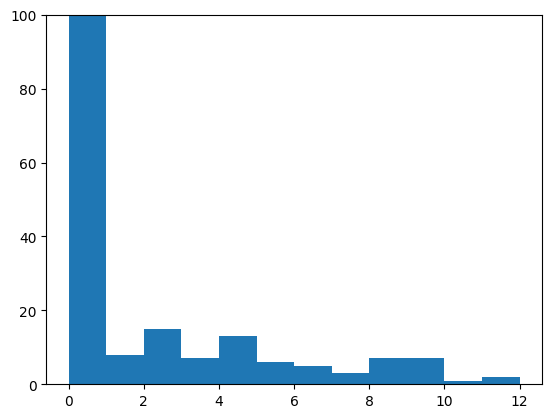

In [16]:
plt.hist(df_corr_regresion_problem['orig_lang_num'],bins=12)
plt.ylim(0, 100)
plt.show()

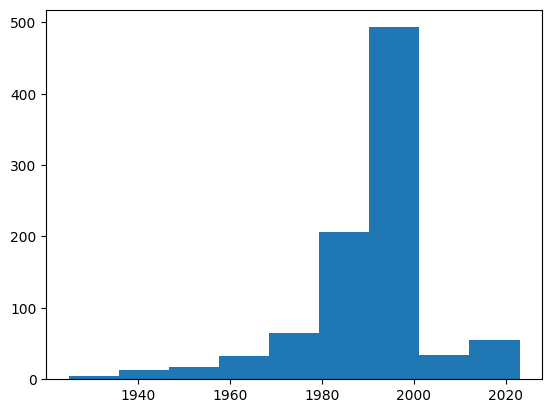

In [17]:
plt.hist(df_corr_regresion_problem['year'],bins=9)
plt.show()

In [18]:
generos = ['Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 
           'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
           'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

X = df_corr_regresion_problem[generos]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X_scaled)  # X_scaled es el dataset de géneros ya normalizado


In [19]:
pca_columns = [f'PCA_genre_{i+1}' for i in range(11)]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)

In [20]:
pca_columns = [f'PCA_genre_{i+1}' for i in range(11)]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)
df_pca
print("\n\n",df_pca.shape)



 (920, 11)


In [21]:
df_corr_regresion_problem.reset_index(drop=True, inplace=True)
df_pca.reset_index(drop=True, inplace=True)

df_regresion_pca_genres = pd.concat([df_corr_regresion_problem, df_pca], axis=1)
df_regresion_pca_genres.drop(columns=generos, inplace=True)
percent_data_NaN(df_regresion_pca_genres)
print(df_regresion_pca_genres.shape)


El 0.00% de las filas tienen al menos un campo NaN.
(920, 20)


In [22]:
df_set = df_regresion_pca_genres.drop(columns=['genre_imdb'])

In [ ]:
def get_last_digit(movieid):
    return int(str(movieid)[-1])

df_set['last_digit'] = df_set['MovieID'].apply(get_last_digit)

train_data = df_set[df_set['last_digit'].isin([0, 1, 2, 3, 4, 5, 6])]
validation_data = df_set[df_set['last_digit'].isin([7, 8, 9])]

train_data = train_data.drop(columns=['last_digit'])
validation_data = validation_data.drop(columns=['last_digit'])

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")

train_data.to_csv('train_data.csv', index=False)
validation_data.to_csv('validation_data.csv', index=False)



Train data shape: (645, 19)
Validation data shape: (275, 19)


In [24]:
set_only_linear_rev=df_set.drop(columns=['log_percentual_gain'])

In [ ]:

train_data_2 = set_only_linear_rev[set_only_linear_rev['last_digit'].isin([0, 1, 2, 3, 4, 5, 6])]
validation_data_2 = set_only_linear_rev[set_only_linear_rev['last_digit'].isin([7, 8, 9])]

train_data_2 = train_data_2.drop(columns=['last_digit'])
validation_data_2 = validation_data_2.drop(columns=['last_digit'])

print(f"Train data shape: {train_data_2.shape}")
print(f"Validation data shape: {validation_data_2.shape}")

train_data_2.to_csv('train_data_only_linear_rev.csv', index=False)
validation_data_2.to_csv('validation_data_only_linear_rev.csv', index=False)

Train data shape: (645, 18)
Validation data shape: (275, 18)


CARGAR DATASETS

In [26]:
dataset_train_full="train_data.csv"
dataset_train_only_linear_rev="train_data_only_linear_rev.csv"

In [27]:
df_train_full = pd.read_csv(dataset_train_full, encoding="latin-1")
df_train_only_linear_rev=pd.read_csv(dataset_train_only_linear_rev, encoding="latin-1")

In [28]:
df_train_full

,MovieID,score,budget_x,revenue,country,log_percentual_gain,year,orig_lang_num,PCA_genre_1,PCA_genre_2,PCA_genre_3,PCA_genre_4,PCA_genre_5,PCA_genre_6,PCA_genre_7,PCA_genre_8,PCA_genre_9,PCA_genre_10,PCA_genre_11
0,1193,84.0,4400000.0,163274115.0,0,35.694647,1976,0,-0.489470,-1.029568,0.101283,0.859348,0.587910,-0.164803,0.538657,-0.317965,-0.179226,-0.591331,0.113154
1,661,65.0,38000000.0,28946127.0,0,18.818069,1997,0,6.746440,-0.580165,3.262993,0.799990,1.840483,1.721913,-2.088572,1.071251,0.384655,-0.705020,-0.748565
2,914,75.0,17000000.0,72072607.0,1,26.273213,1964,0,1.752970,-1.599035,0.608850,0.560141,0.397395,0.340700,-3.337704,1.853763,1.759295,-0.407723,-2.197963
3,594,71.0,1488000.0,184925486.0,0,40.943938,1938,0,6.746440,-0.580165,3.262993,0.799990,1.840483,1.721913,-2.088572,1.071251,0.384655,-0.705020,-0.748565
4,2791,73.0,3500000.0,83453539.0,0,33.773767,1980,0,0.237259,-0.914192,-0.522905,-1.248294,-0.746277,0.248730,-0.052316,0.051800,-0.395993,0.326002,0.442964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,1142,56.0,10000000.0,19860259.0,1,22.979849,2001,0,-0.489470,-1.029568,0.101283,0.859348,0.587910,-0.164803,0.538657,-0.317965,-0.179226,-0.591331,0.113154
641,3652,63.0,87000000.0,476680473.8,12,27.387081,1980,5,-0.352201,-0.085045,0.220199,-1.821910,1.745621,-0.939438,0.342921,-0.503255,-0.514724,-0.277271,-0.351197
642,2226,71.0,1200000.0,19400000.0,0,32.086205,2001,2,-0.489470,-1.029568,0.101283,0.859348,0.587910,-0.164803,0.538657,-0.317965,-0.179226,-0.591331,0.113154
643,1430,68.0,22000000.0,95708457.0,0,26.385276,2004,0,-0.716390,0.468851,0.946556,-0.324530,0.273148,-0.132766,-0.240193,0.161077,0.574416,-0.083712,-0.007175


In [29]:
conteo_orig_lang = df_train_full['orig_lang_num'].value_counts()
print(conteo_orig_lang)

orig_lang_num
0     583
4      13
2      11
1       6
8       6
3       5
5       5
6       5
9       5
7       3
10      1
11      1
12      1
Name: count, dtype: int64


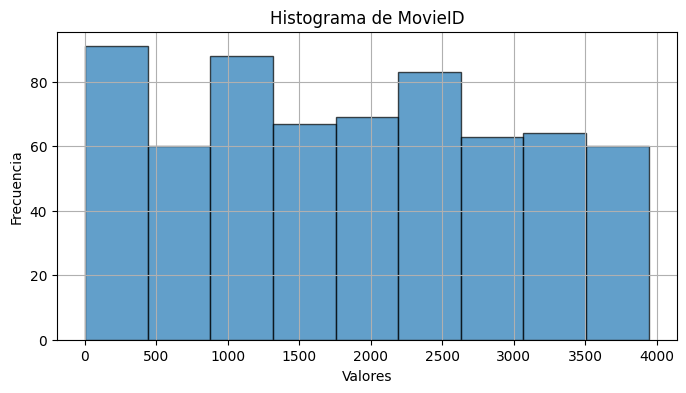

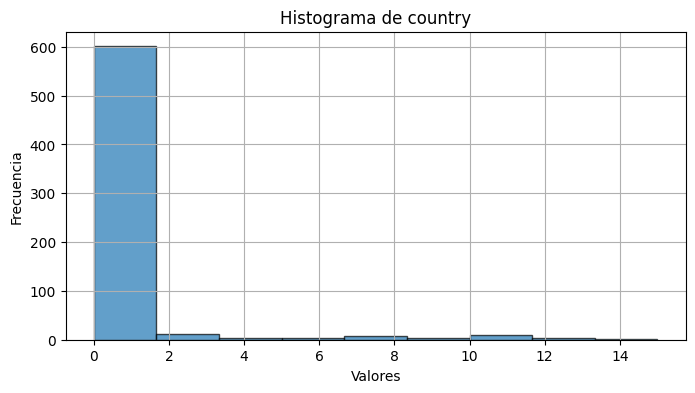

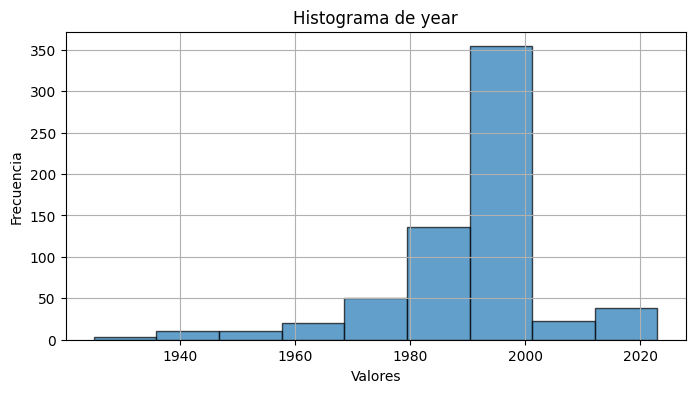

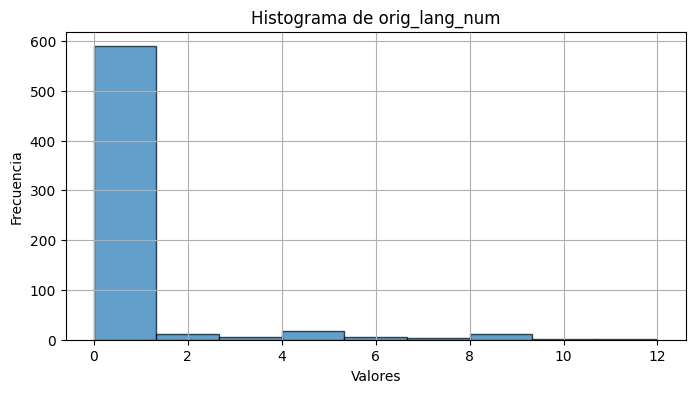

In [30]:
columns_int_mapped = df_train_full.select_dtypes(include=['int']).columns

for column in columns_int_mapped:
    plt.figure(figsize=(8, 4))
    plt.hist(df_train_full[column], bins=9, edgecolor='k', alpha=0.7)
    plt.title(f"Histograma de {column}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

In [31]:
def percent_data_NaN(_df):
    nan_rows_count = _df.isnull().any(axis=1).sum()  # Número de filas con al menos un NaN
    total_rows = len(_df)  # Número total de filas
    nan_percentage = (nan_rows_count / total_rows) * 100  # Porcentaje de filas con NaN
    print(f"El {nan_percentage:.2f}% de las filas tienen al menos un campo NaN.")

In [32]:

def asignar_valor_flotante_con_ruido(media, std_dev, size=1):
    """Asigna valores flotantes con ruido basado en la desviación estándar."""
    ruido = np.random.normal(0, std_dev, size=size)[0] / 10
    res=media + ruido
    if res < 0:
        res = abs(res)
    return res

# Función para obtener el idioma predominante en un país específico
def obtener_idioma_predominante(df, pais):
    """Obtiene el idioma predominante en un país específico."""
    df_pais = df[df['country'] == pais]
    return df_pais['orig_lang_num'].mode()[0]




def calcular_estadisticas_por_decada(df, decades):
    estadisticas_por_decada = {}
    
    for start_year, end_year in decades:
        mask = (df['year'] >= start_year) & (df['year'] < end_year)
        df_decade = df[mask]
        
        if not df_decade.empty:
            stats = {}
            for column in df_decade.select_dtypes(include=[np.float64]).columns:
                stats[column] = {
                    'mean': df_decade[column].mean(),
                    'std': df_decade[column].std()
                }
            estadisticas_por_decada[(start_year, end_year)] = stats
    
    return estadisticas_por_decada


def agregar_peliculas_por_decada(df, decades, min_thresh=30, target_count=30, seed_base=42):
    
    estadisticas_por_decada = calcular_estadisticas_por_decada(df, decades)
    
    paises = df['country'].value_counts(normalize=True)
    
    new_movies = []
    
    for start_year, end_year in decades:
        mask = (df['year'] >= start_year) & (df['year'] < end_year)
        df_decade = df[mask]
        
        current_count = df_decade.shape[0]
        
        if current_count >= min_thresh:
            continue  # Si ya hay suficientes películas, no se agrega nada
        
        num_to_add = min_thresh - current_count
        
        stats_decada = estadisticas_por_decada.get((start_year, end_year), {})
        
        for i in range(num_to_add):
            random.seed(seed_base + start_year + i)
            
            new_movie = {}
            new_movie['MovieID'] = random.randint(20000, 30000)
            new_movie['year'] = random.randint(start_year, end_year - 1) 
            
            # Asignar el país de manera probabilística
            pais = random.choices(paises.index, weights=paises.values, k=1)[0]
            new_movie['country'] = pais
            
            # Asignar el idioma predominante para ese país
            new_movie['orig_lang_num'] = obtener_idioma_predominante(df, pais)
            
            # Asignar valores para los features flotantes
            for column, stats in stats_decada.items():
                media = stats['mean']
                std_dev = stats['std']
                new_movie[column] = asignar_valor_flotante_con_ruido(media, std_dev)
            
            new_movies.append(new_movie)
    
    new_movies_df = pd.DataFrame(new_movies)
    return new_movies_df


In [33]:
decades_vector = [(1930, 1940), (1940, 1950), (1950, 1960), (1960, 1970),(1970, 1980), (1980, 1990), (2000, 2010), (2010, 2020)]

In [34]:
df_train_full_year_extension = agregar_peliculas_por_decada(df_train_full,decades_vector)
df_train_only_linear_rev_year_extension=agregar_peliculas_por_decada(df_train_only_linear_rev,decades_vector)

In [35]:
print(percent_data_NaN(df_train_full_year_extension))
print(percent_data_NaN(df_train_only_linear_rev_year_extension))

El 0.00% de las filas tienen al menos un campo NaN.
None
El 0.00% de las filas tienen al menos un campo NaN.
None


In [36]:

def agregar_pelicula_de_a_una(df_pelis, country_value,cantidad):
    # Filtrar películas del país especificado
    peliculas_pais = df_pelis[df_pelis['country'] == country_value]
    nueva_pelicula = {}

    # Asignar un MovieID aleatorio entre 40000 y 50000
    nueva_pelicula['MovieID'] = random.randint(40000, 50000)
    
    # Recorrer las columnas para rellenar los valores
    for col in df_pelis.columns:
        if col == 'MovieID':
            continue
            
        col_type = df_pelis[col].dtype
        
        # Si la columna es tipo float, asignar (media + 0.1 * desviación estándar)
        if np.issubdtype(col_type, np.float64):
            if cantidad>1:
                media = peliculas_pais[col].mean()
                std = peliculas_pais[col].std()
                nueva_pelicula[col] = media + (0.1 * std)
            else:
                nueva_pelicula[col]=peliculas_pais[col].iloc[0]
        
        elif np.issubdtype(col_type, np.integer):
            nueva_pelicula[col] = peliculas_pais[col].iloc[-1]  # Último valor
            
    # Convertir la nueva película en DataFrame de una fila
    df_nueva_pelicula = pd.DataFrame([nueva_pelicula])

    return df_nueva_pelicula

In [37]:
def agregar_peliculas_por_pais(df, target=20):
    
    columnas = df.columns
    df_nuevo = pd.DataFrame(columns=columnas)
    
    # Bucle para agregar el número de películas que quieras
    for pais, count in df['country'].value_counts().items():
        if count < target:
            # Clonar las películas existentes
            for i in range(round(target/count)):
                nueva_pelicula = agregar_pelicula_de_a_una(df, pais,count)
                
                # Evitar concatenar DataFrames vacíos
                if not nueva_pelicula.empty:
                    df_nuevo = pd.concat([df_nuevo, nueva_pelicula], ignore_index=True)
    
    return df_nuevo

In [38]:
df_extension_country_full_train = agregar_peliculas_por_pais(df_train_full)
df_extension_country_only_linear_rev=agregar_peliculas_por_pais(df_train_only_linear_rev)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_2644\1117250585.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nuevo = pd.concat([df_nuevo, nueva_pelicula], ignore_index=True)
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_2644\1117250585.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nuevo = pd.concat([df_nuevo, nueva_pelicula], ignore_index=True)


In [39]:
print(percent_data_NaN(df_extension_country_full_train))
print(percent_data_NaN(df_extension_country_only_linear_rev))

El 0.00% de las filas tienen al menos un campo NaN.
None
El 0.00% de las filas tienen al menos un campo NaN.
None


CORRIJO LAS NO ALINEALIDADES

In [40]:
def aplicar_log_percentual_gain(df):
    df["log_percentual_gain"] = (df["revenue"] / df["budget_x"]) * 100
    df['log_percentual_gain'] = df['log_percentual_gain'].apply(lambda x: -30 if x == 0 else 10 * np.log10(x))
    return df

In [41]:
df_extension_country_full_train=aplicar_log_percentual_gain(df_extension_country_full_train)
df_train_full_year_extension = aplicar_log_percentual_gain(df_train_full_year_extension)


In [42]:
#df_train_full_extended= pd.concat([df_train_full,df_train_full_year_extension], ignore_index=True)
df_train_full_extended= pd.concat([df_train_full, df_extension_country_full_train,df_train_full_year_extension], ignore_index=True)
df_train_only_linear_rev_extended= pd.concat([df_train_only_linear_rev, df_extension_country_only_linear_rev,df_train_only_linear_rev_year_extension], ignore_index=True)

In [43]:
df_train_full_extended

,MovieID,score,budget_x,revenue,country,log_percentual_gain,year,orig_lang_num,PCA_genre_1,PCA_genre_2,PCA_genre_3,PCA_genre_4,PCA_genre_5,PCA_genre_6,PCA_genre_7,PCA_genre_8,PCA_genre_9,PCA_genre_10,PCA_genre_11
0,1193,84.000000,4.400000e+06,1.632741e+08,0,35.694647,1976,0,-0.489470,-1.029568,0.101283,0.859348,0.587910,-0.164803,0.538657,-0.317965,-0.179226,-0.591331,0.113154
1,661,65.000000,3.800000e+07,2.894613e+07,0,18.818069,1997,0,6.746440,-0.580165,3.262993,0.799990,1.840483,1.721913,-2.088572,1.071251,0.384655,-0.705020,-0.748565
2,914,75.000000,1.700000e+07,7.207261e+07,1,26.273213,1964,0,1.752970,-1.599035,0.608850,0.560141,0.397395,0.340700,-3.337704,1.853763,1.759295,-0.407723,-2.197963
3,594,71.000000,1.488000e+06,1.849255e+08,0,40.943938,1938,0,6.746440,-0.580165,3.262993,0.799990,1.840483,1.721913,-2.088572,1.071251,0.384655,-0.705020,-0.748565
4,2791,73.000000,3.500000e+06,8.345354e+07,0,33.773767,1980,0,0.237259,-0.914192,-0.522905,-1.248294,-0.746277,0.248730,-0.052316,0.051800,-0.395993,0.326002,0.442964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,22279,75.373358,9.809387e+06,3.698948e+07,0,25.764363,1967,0,0.560484,0.037462,0.100336,0.557827,0.054143,0.192876,0.419365,0.098795,0.632121,0.327807,0.318690
848,28492,73.702277,9.134709e+06,3.629904e+07,1,25.992004,1968,0,0.440613,0.492299,0.141639,0.508716,0.180262,0.212257,0.294128,0.160407,0.170069,0.379194,0.153217
849,25417,66.689528,4.655544e+07,1.213850e+08,0,24.161945,2018,0,0.481703,0.079072,0.001013,0.142238,0.689579,0.202911,0.567459,0.633101,0.148201,0.039122,0.409323
850,24785,65.941581,4.417086e+07,1.185224e+08,1,24.286647,2019,0,0.551789,0.001496,0.053601,0.144461,0.595348,0.325495,0.482836,0.287347,0.033245,0.082863,0.290182


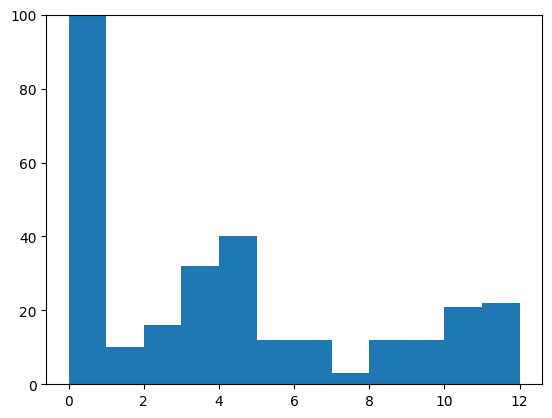

In [44]:
plt.hist(df_train_full_extended['orig_lang_num'],bins=12)
plt.ylim(0, 100)
plt.show()

In [45]:
conteo_orig_lang = df_train_full_extended['orig_lang_num'].value_counts()
print(conteo_orig_lang)


orig_lang_num
0     660
4      40
3      32
10     21
12     21
2      16
5      12
6      12
8      12
9      12
1      10
7       3
11      1
Name: count, dtype: int64


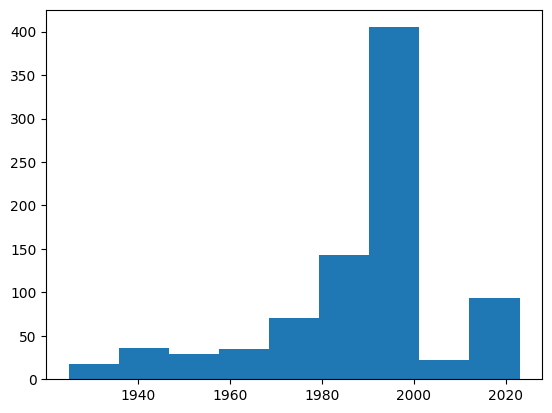

In [46]:
plt.hist(df_train_full_extended['year'],bins=9)
plt.show()

In [47]:
df_train_full_extended

,MovieID,score,budget_x,revenue,country,log_percentual_gain,year,orig_lang_num,PCA_genre_1,PCA_genre_2,PCA_genre_3,PCA_genre_4,PCA_genre_5,PCA_genre_6,PCA_genre_7,PCA_genre_8,PCA_genre_9,PCA_genre_10,PCA_genre_11
0,1193,84.000000,4.400000e+06,1.632741e+08,0,35.694647,1976,0,-0.489470,-1.029568,0.101283,0.859348,0.587910,-0.164803,0.538657,-0.317965,-0.179226,-0.591331,0.113154
1,661,65.000000,3.800000e+07,2.894613e+07,0,18.818069,1997,0,6.746440,-0.580165,3.262993,0.799990,1.840483,1.721913,-2.088572,1.071251,0.384655,-0.705020,-0.748565
2,914,75.000000,1.700000e+07,7.207261e+07,1,26.273213,1964,0,1.752970,-1.599035,0.608850,0.560141,0.397395,0.340700,-3.337704,1.853763,1.759295,-0.407723,-2.197963
3,594,71.000000,1.488000e+06,1.849255e+08,0,40.943938,1938,0,6.746440,-0.580165,3.262993,0.799990,1.840483,1.721913,-2.088572,1.071251,0.384655,-0.705020,-0.748565
4,2791,73.000000,3.500000e+06,8.345354e+07,0,33.773767,1980,0,0.237259,-0.914192,-0.522905,-1.248294,-0.746277,0.248730,-0.052316,0.051800,-0.395993,0.326002,0.442964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,22279,75.373358,9.809387e+06,3.698948e+07,0,25.764363,1967,0,0.560484,0.037462,0.100336,0.557827,0.054143,0.192876,0.419365,0.098795,0.632121,0.327807,0.318690
848,28492,73.702277,9.134709e+06,3.629904e+07,1,25.992004,1968,0,0.440613,0.492299,0.141639,0.508716,0.180262,0.212257,0.294128,0.160407,0.170069,0.379194,0.153217
849,25417,66.689528,4.655544e+07,1.213850e+08,0,24.161945,2018,0,0.481703,0.079072,0.001013,0.142238,0.689579,0.202911,0.567459,0.633101,0.148201,0.039122,0.409323
850,24785,65.941581,4.417086e+07,1.185224e+08,1,24.286647,2019,0,0.551789,0.001496,0.053601,0.144461,0.595348,0.325495,0.482836,0.287347,0.033245,0.082863,0.290182


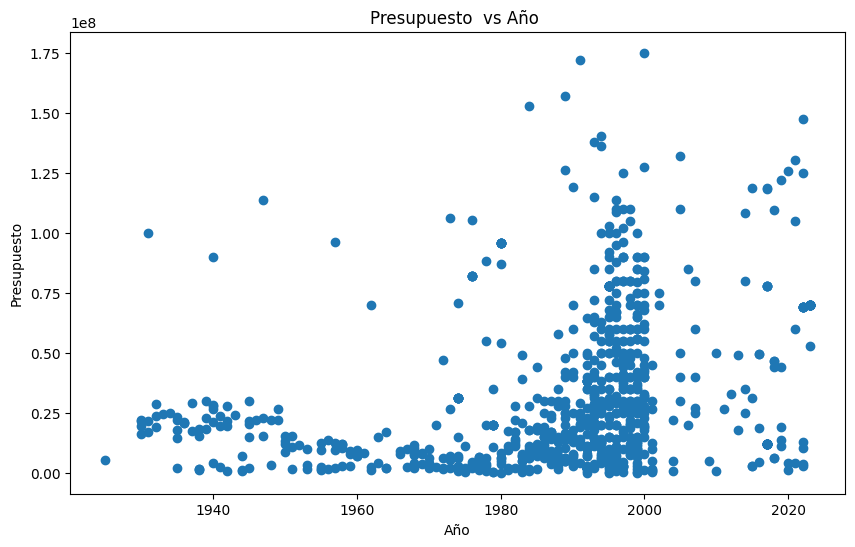

In [48]:
plt.figure(figsize=(10,6))
plt.scatter(df_train_full_extended['year'], df_train_full_extended['budget_x'])
plt.xlabel('Año')
plt.ylabel('Presupuesto')
plt.title('Presupuesto  vs Año ')
plt.show()


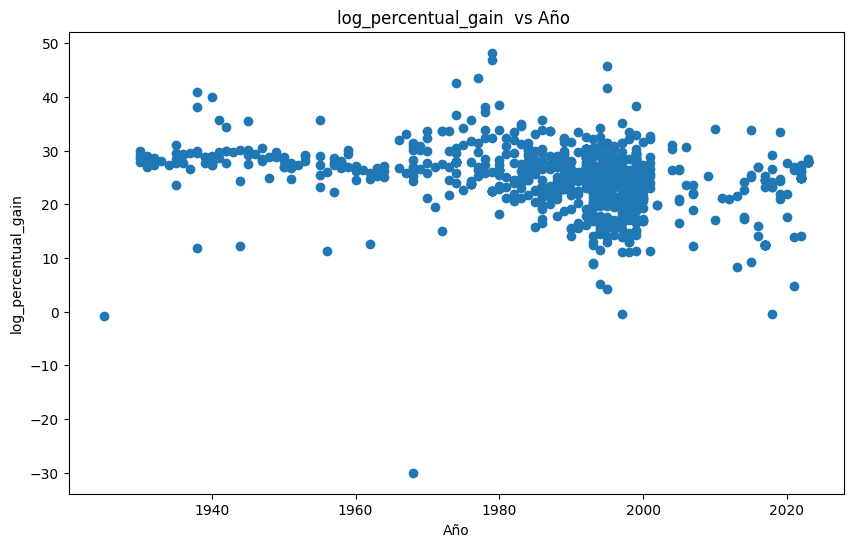

In [49]:
plt.figure(figsize=(10,6))
plt.scatter(df_train_full_extended['year'], df_train_full_extended['log_percentual_gain'])
plt.xlabel('Año')
plt.ylabel('log_percentual_gain')
plt.title('log_percentual_gain  vs Año ')
plt.show()

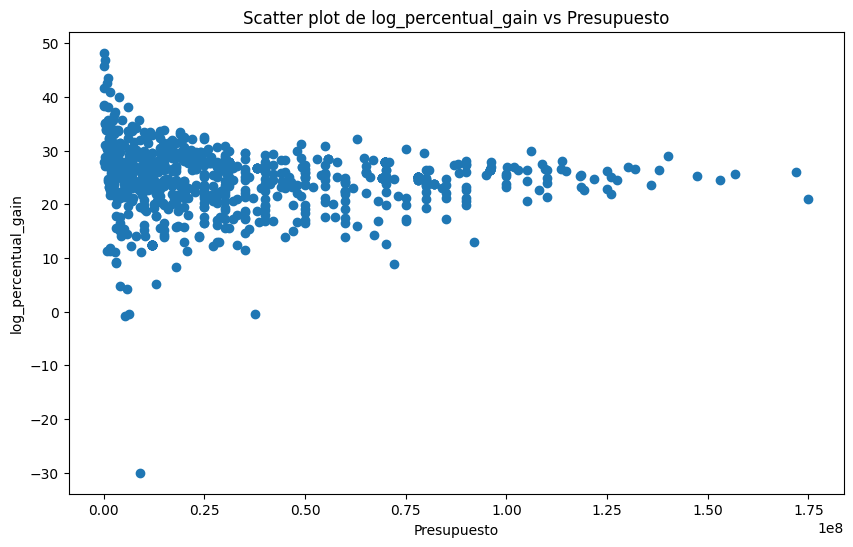

In [50]:
plt.figure(figsize=(10,6))

plt.scatter(df_train_full_extended['budget_x'], df_train_full_extended['log_percentual_gain'])

plt.xlabel('Presupuesto')
plt.ylabel('log_percentual_gain')
plt.title('Scatter plot de log_percentual_gain vs Presupuesto')
plt.show()

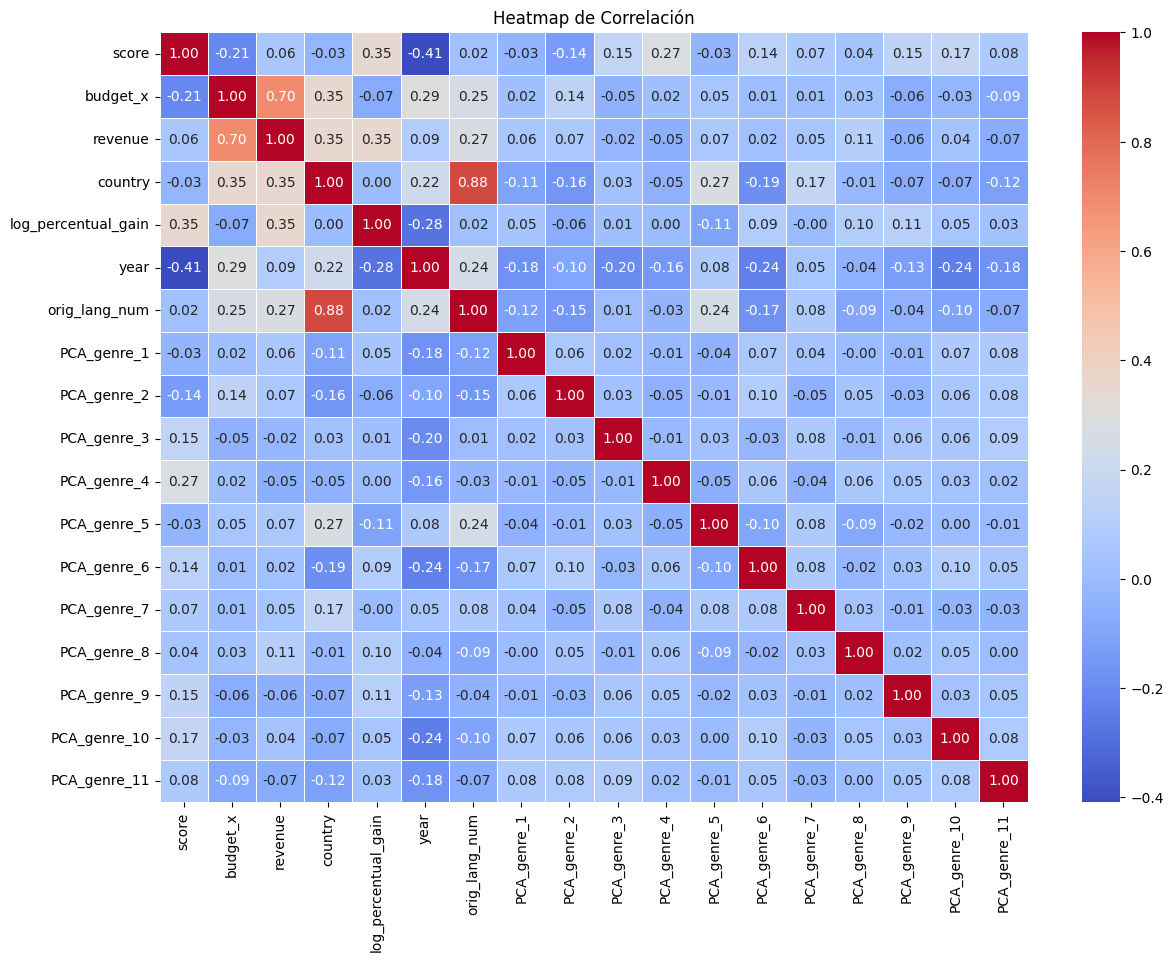

In [51]:
df_corr = df_train_full_extended.drop(columns=['MovieID'])

correlation_matrix = df_corr.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap de Correlación')
plt.show()

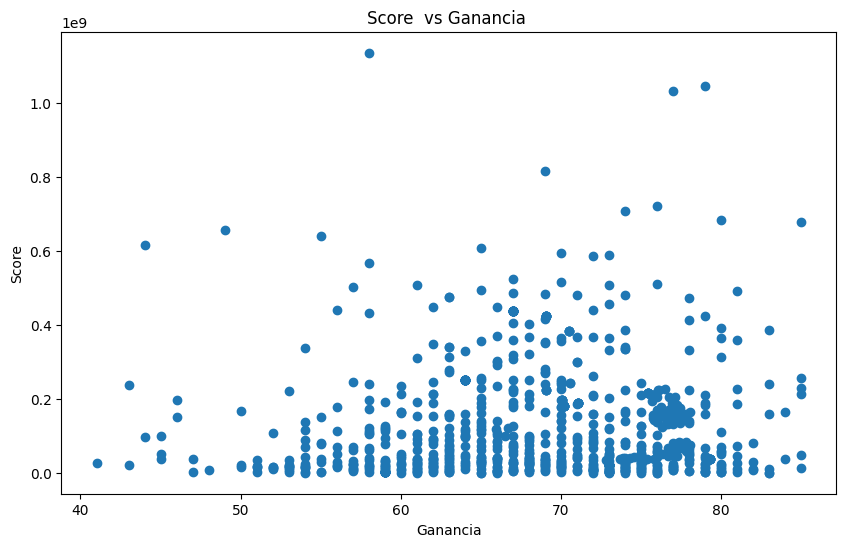

In [52]:
plt.figure(figsize=(10,6))
plt.scatter(df_train_full_extended['score'], df_train_full_extended['revenue'])
plt.xlabel('Ganancia')
plt.ylabel('Score')
plt.title('Score  vs Ganancia ')
plt.show()


In [53]:
df_train_full_extended=df_train_full_extended.drop(columns=['MovieID'])

In [54]:
columns_int_mapped = df_train_full_extended.select_dtypes(include=['int']).columns

for column in columns_int_mapped:
    plt.figure(figsize=(8, 4))
    plt.hist(df_train_full_extended[column], bins=9, edgecolor='k', alpha=0.7)
    plt.title(f"Histograma de {column}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

MODELO FULL CON REVENUE LINEAL+LOG

In [55]:
y = df_train_full_extended['revenue']
X = df_train_full_extended.drop('revenue', axis=1)

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
dataset_test_full="validation_data.csv"
df_test_full = pd.read_csv(dataset_test_full, encoding="latin-1")
df_test_full = df_test_full.sample(frac=1, random_state=42).reset_index(drop=True)
df_test_full = df_test_full.drop(columns=['MovieID'])

In [58]:
y_test = df_test_full['revenue']
X_test = df_test_full.drop('revenue', axis=1)

In [59]:

## Creo haber notado una relación gaussiana entre el Score y Revenue
def gaussian_transform(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

mu_score = X_train['score'].mean()  # Media del feature score
sigma_score = X_train['score'].std()  # Desviación estándar del score

# Aplicar la transformación gaussiana
X_train['score_gaussian'] = gaussian_transform(X_train['score'], mu_score, sigma_score)
X_val['score_gaussian'] = gaussian_transform(X_val['score'], mu_score, sigma_score)
X_test['score_gaussian'] = gaussian_transform(X_test['score'], mu_score, sigma_score)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


X_train_poly = X_train_scaled
X_val_poly = X_val_scaled
X_test_poly = X_test_scaled

In [60]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_poly, y_train)

GradientBoostingRegressor(random_state=42)

In [61]:
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    print(f"{dataset_name} RMSE: {rmse:.4f}")
    print(f"{dataset_name} R²: {r2:.4f}")
    return rmse, r2

# Evaluación en conjunto de entrenamiento
train_rmse, train_r2 = evaluate_model(model, X_train_poly, y_train, "Train")

# Evaluación en conjunto de validación
val_rmse, val_r2 = evaluate_model(model, X_val_poly, y_val, "Validation")

Train RMSE: 9918058.7890
Train R²: 0.9960
Validation RMSE: 21518348.4359
Validation R²: 0.9768


In [62]:
# Evaluar en el conjunto de test
test_rmse_full_model, test_r2_full_model = evaluate_model(model, X_test_poly, y_test, "Test")

Test RMSE: 42661652.0229
Test R²: 0.9351


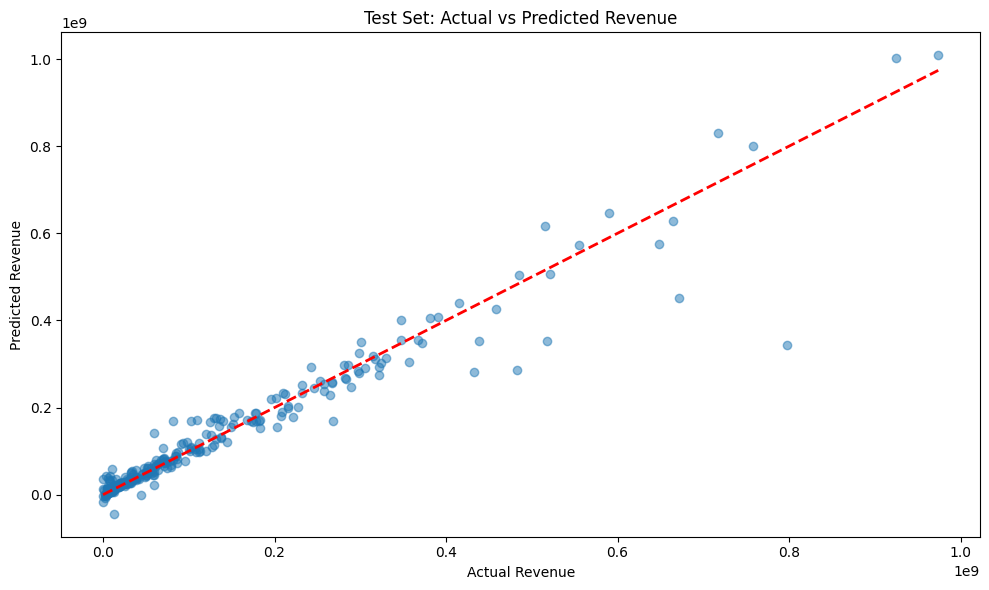

In [63]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Actual Revenue")
    plt.ylabel("Predicted Revenue")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Generar predicciones para el conjunto de test
y_test_pred = model.predict(X_test_poly)

# Visualizar las predicciones vs valores reales
plot_predictions(y_test, y_test_pred, "Test Set: Actual vs Predicted Revenue")

MODELO REVENUE SOLO LINEAL

In [64]:
df_train_only_linear_rev_extended=df_train_only_linear_rev_extended.drop(columns=['MovieID'])

In [65]:
y_LIN = df_train_only_linear_rev_extended['revenue']
X_LIN = df_train_only_linear_rev_extended.drop('revenue', axis=1)

In [66]:
X_train_LIN, X_val_LIN, y_train_LIN, y_val_LIN = train_test_split(X_LIN, y_LIN, test_size=0.2, random_state=42)

In [67]:
y_train_LIN

785    1.293834e+08
101    3.395043e+08
787    1.802257e+08
530    5.170293e+07
430    2.295490e+05
           ...     
71     3.282035e+08
106    2.120270e+08
270    8.456523e+07
435    2.368988e+07
102    1.253278e+07
Name: revenue, Length: 681, dtype: float64

In [68]:
dataset_test_LIN="validation_data_only_linear_rev.csv"
df_test_LIN = pd.read_csv(dataset_test_LIN, encoding="latin-1")
df_test_LIN = df_test_full.sample(frac=1, random_state=42).reset_index(drop=True)

In [69]:
df_test_LIN=df_test_LIN.drop(columns=['log_percentual_gain'])

In [70]:
y_test_Lin = df_test_LIN['revenue']
X_test_Lin = df_test_LIN.drop('revenue', axis=1)

In [71]:


X_train_scaled_Lin = scaler.fit_transform(X_train_LIN)
X_val_scaled_Lin = scaler.transform(X_val_LIN)
X_test_scaled_Lin = scaler.transform(X_test_Lin)

lineal_rev_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
lineal_rev_model.fit(X_train_scaled_Lin, y_train_LIN)

GradientBoostingRegressor(random_state=42)

In [72]:
train_rmse, train_r2 = evaluate_model(lineal_rev_model, X_train_scaled_Lin, y_train_LIN, "Train")

# Evaluación en conjunto de validación
val_rmse, val_r2 = evaluate_model(lineal_rev_model, X_val_scaled_Lin, y_val_LIN, "Validation")

Train RMSE: 55178396.3756
Train R²: 0.8759
Validation RMSE: 101430380.2221
Validation R²: 0.4826


In [80]:
test_rmse_lineal_model, test_r2_lineal_model = evaluate_model(lineal_rev_model, X_test_scaled_Lin, y_test_Lin, "Test")

Test RMSE: 139627574.8563
Test R²: 0.3049


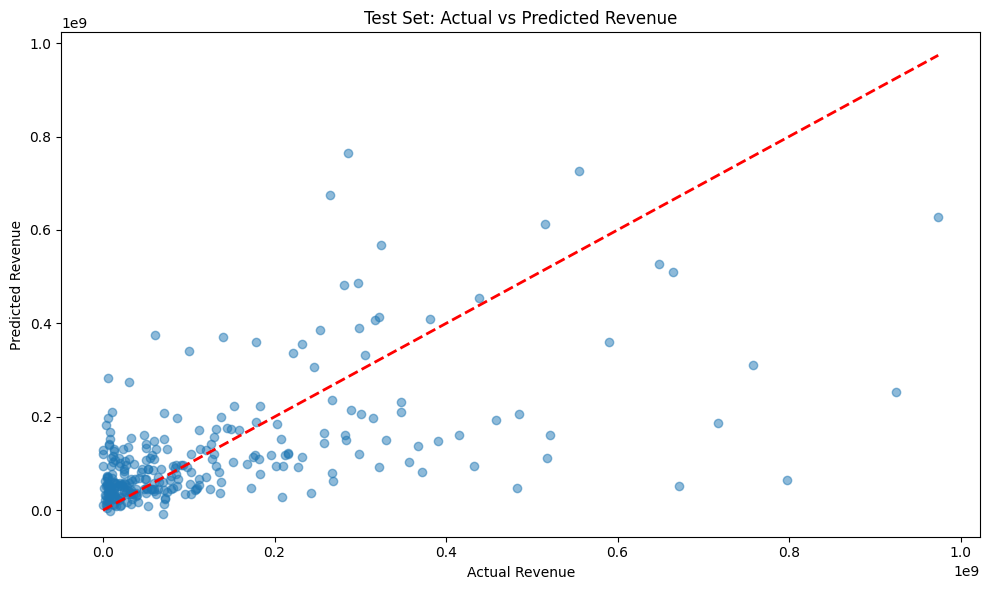

In [74]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Actual Revenue")
    plt.ylabel("Predicted Revenue")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Generar predicciones para el conjunto de test
y_test_pred = lineal_rev_model.predict(X_test_scaled_Lin)

# Visualizar las predicciones vs valores reales
plot_predictions(y_test_Lin, y_test_pred, "Test Set: Actual vs Predicted Revenue")

In [75]:
n_estimators_values = [100, 200, 300]
learning_rate_values = np.logspace(-3, -1, 10)
max_depth_values = [2, 3, 4]

best_r2 = -np.inf
best_model = None
best_params = {}

for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        for max_depth in max_depth_values:
            
            model = GradientBoostingRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )
            model.fit(X_train_scaled_Lin, y_train_LIN)

            test_rmse, test_r2 = evaluate_model(model, X_test_scaled_Lin, y_test_Lin, "Test")
            
            if test_r2 > best_r2:
                best_r2 = test_r2
                best_model = model
                best_test_rmse = test_rmse
                best_params = {
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth
                }

print(f"Best Model Parameters: {best_params}")
print(f"Best Test R2: {best_r2:.4f}")
print(f"Best Test RMSE: {test_rmse:.4f}")

Test RMSE: 161151372.5237
Test R²: 0.0740
Test RMSE: 160751694.8666
Test R²: 0.0786
Test RMSE: 160062696.0428
Test R²: 0.0865
Test RMSE: 157477100.0822
Test R²: 0.1158
Test RMSE: 157097659.7515
Test R²: 0.1200
Test RMSE: 155943622.9436
Test R²: 0.1329
Test RMSE: 152801219.3921
Test R²: 0.1675
Test RMSE: 151805939.8652
Test R²: 0.1783
Test RMSE: 151030186.5461
Test R²: 0.1867
Test RMSE: 146423871.2749
Test R²: 0.2355
Test RMSE: 144785236.8685
Test R²: 0.2525
Test RMSE: 144603935.6333
Test R²: 0.2544
Test RMSE: 139248788.6012
Test R²: 0.3086
Test RMSE: 137865146.2723
Test R²: 0.3223
Test RMSE: 138672626.9884
Test R²: 0.3143
Test RMSE: 132739545.8433
Test R²: 0.3717
Test RMSE: 132660794.5883
Test R²: 0.3725
Test RMSE: 133179133.9370
Test R²: 0.3676
Test RMSE: 129349925.7822
Test R²: 0.4034
Test RMSE: 131381734.0444
Test R²: 0.3845
Test RMSE: 131651274.8203
Test R²: 0.3820
Test RMSE: 129344454.3884
Test R²: 0.4035
Test RMSE: 133368774.8453
Test R²: 0.3658
Test RMSE: 134462325.3381
Test R²:

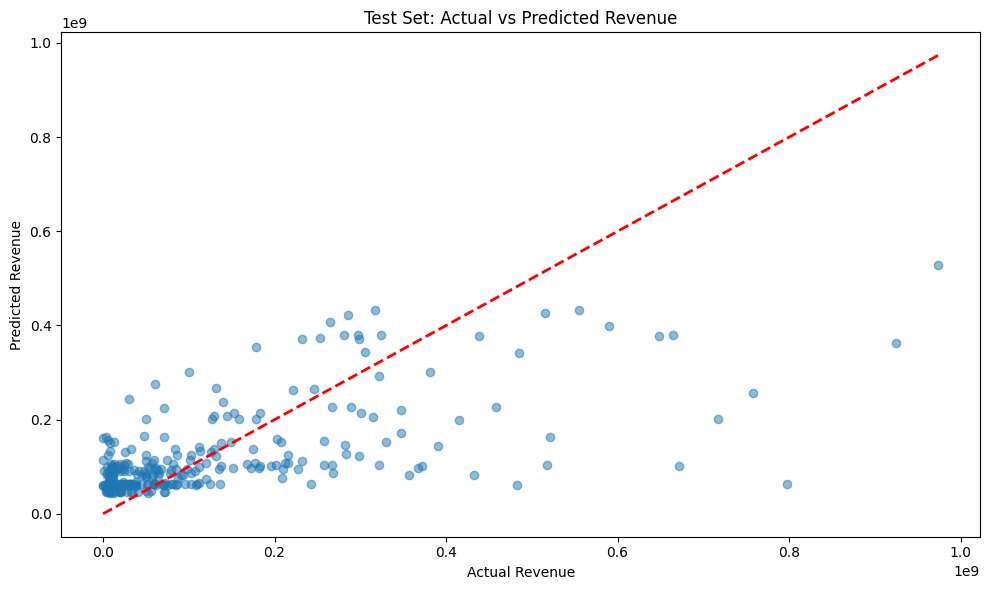

In [76]:
y_test_pred = best_model.predict(X_test_scaled_Lin)
plot_predictions(y_test_Lin, y_test_pred, "Test Set: Actual vs Predicted Revenue")

In [77]:
models = ['full_model', 'only_lineal_features', 'improved_only_lineal_features']
metrics = ['r2', 'RMSE']

data = [[None for _ in range(len(models))] for _ in range(len(metrics))]


In [94]:
data[0][0] = test_r2_full_model
data[1][0] = test_rmse_full_model
data[0][1] = test_r2_lineal_model
data[1][1] = test_rmse_lineal_model
data[0][2] = best_r2
data[1][2] = test_rmse
# Crear el DataFrame y formatear
df = pd.DataFrame(data, index=metrics, columns=models)


print(df)

        full_model  only_lineal_features  improved_only_lineal_features
r2    9.351052e-01          3.048528e-01                   4.047568e-01
RMSE  4.266165e+07          1.396276e+08                   1.443877e+08
